<a href="https://colab.research.google.com/github/mferri17/amazon-reviews-sentiment-network-analysis/blob/master/network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Reviews Network Analysis - Ferri Marco, Basso Matteo

This project aims to experiment with network analysis on [Amazon Reviews](http://jmcauley.ucsd.edu/data/amazon/) in order to build a collaborative filtering model.

## Dataset

### Dependencies

In [0]:
import os
import gzip
import fileinput
import sys
import datetime
import io
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fastai.collab import *
from sklearn.utils import resample

### Reading


Util functions to read from JSON and convert into pandas dataframe:

In [0]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  df = []
  for d in parse(path):
    df.append(d)
  return pd.DataFrame(df)

def read_dataset(dataset):      
  basepath = r"datasets\amazon-5-core"
  df = getDF(os.path.join(basepath, dataset))
  return df
  
def download_dataset(dataset):
  request = urllib.request.Request('http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/' + dataset)
  request.add_header('Accept-encoding', 'gzip')
  response = urllib.request.urlopen(request)
  buf = io.BytesIO(response.read())
  file = gzip.GzipFile(fileobj=buf)
  df = []
  for line in file:
    df.append(eval(line))
  return pd.DataFrame(df)

Reading from JSON

In [3]:
#%time dfull = read_dataset("reviews_Video_Games_5.json.gz")
%time dfull = download_dataset('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')

CPU times: user 11.4 s, sys: 339 ms, total: 11.7 s
Wall time: 16.2 s


---

###  Description

#### Schema

In [4]:
print("(rows, cols) = ", dfull.shape)

(rows, cols) =  (278677, 9)


In [0]:
dfull = dfull.rename(index=str, columns={"asin": "productID", 
                                         "reviewerID": "userID", 
                                         "reviewerName": "userName",
                                         "reviewText": "text",
                                         "overall": "rating"})

In [6]:
dfull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 278677 entries, 0 to 278676
Data columns (total 9 columns):
productID         278677 non-null object
helpful           278677 non-null object
rating            278677 non-null float64
text              278677 non-null object
reviewTime        278677 non-null object
userID            278677 non-null object
userName          278225 non-null object
summary           278677 non-null object
unixReviewTime    278677 non-null int64
dtypes: float64(1), int64(1), object(7)
memory usage: 21.3+ MB


In [7]:
dfull.head(3)

,productID,helpful,rating,text,reviewTime,userID,userName,summary,unixReviewTime
0,0000031887,"[0, 0]",5.0,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800
1,0000031887,"[0, 0]",5.0,I bought this for my 4 yr old daughter for dan...,"01 19, 2013",A2G5TCU2WDFZ65,Amazon Customer,Very Cute!!,1358553600
2,0000031887,"[0, 0]",5.0,What can I say... my daughters have it in oran...,"01 4, 2013",A1RLQXYNCMWRWN,Carola,I have buy more than one,1357257600


### Users and products

In [8]:
(rows,cols) = dfull.shape
n_users = dfull['userID'].nunique()
n_products = dfull['productID'].nunique()
print("Number of REVIEWS: ", rows)
print("Number of USERS: ", n_users)
print("Number of PRODUCTS: ", n_products)
print("Average REVIEWS PER USER: ", rows/n_users)
print("Average REVIEWS PER PRODUCT: ", rows/n_products)

Number of REVIEWS:  278677
Number of USERS:  39387
Number of PRODUCTS:  23033
Average REVIEWS PER USER:  7.075354812501587
Average REVIEWS PER PRODUCT:  12.099031823904832


### Manipulation

#### Rejecting columns

In [0]:
dfull = dfull.drop(['helpful', 'reviewTime', 'unixReviewTime', 'userName', 'text', 'summary', 'sentiment'], axis = 1, errors = 'ignore')

In [10]:
dfull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 278677 entries, 0 to 278676
Data columns (total 3 columns):
productID    278677 non-null object
rating       278677 non-null float64
userID       278677 non-null object
dtypes: float64(1), object(2)
memory usage: 8.5+ MB


#### Binarization

Since target variable (`rating`) is strongly unbalanced between low and high values, it is preferable to reduce the problem from multi-class to binary. Later on, some technique to manage unbalancement will be applied to the dataset, in order to fill the gap between the two binary classes.


In [0]:
# dfull['sentiment'] = ['positive' if r > 3 else 'negative' for r in dfull['rating']]

# print("Sentiment count")
# dfull['sentiment'].value_counts()

#### Undersampling

As previously seen, target column (`rating`) is strongly unbalanced towards the positive class. Undersampling of the majority class is necessary here to achieve good machine learning preformances later. This mainly afftects prediction models *recall* metric.

In [0]:

# # Separate majority and minority classes
# positive_count = dfull['sentiment'].value_counts()['positive']
# negative_count = dfull['sentiment'].value_counts()['negative']
# df_majority = dfull[dfull.sentiment==('positive' if positive_count >= negative_count else 'negative')]
# df_minority = dfull[dfull.sentiment==('negative' if positive_count >= negative_count else 'positive')]
 
# # Downsample majority class
# obj_samples = negative_count if positive_count >= negative_count else positive_count
# df_majority_downsampled = resample(df_majority, 
#                                  replace=False,
#                                  n_samples = obj_samples, # match minority class
#                                  random_state=123) # reproducible results
 
# # Combine minority class with downsampled majority class
# df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# # Display new class counts
# print("Positive/negative distribution post-undersampling")
# df_downsampled['sentiment'].value_counts()



---



***

## Network Graph

In [0]:
import scipy.sparse as sparse
import networkx as nx

**Reducing dataset**

In [14]:
print('Original reviews: ', len(dfull))

Original reviews:  278677


In [15]:
dfnet = dfull #[(dfull['date'] > '2014-04-01')]
print('Reduced reviews: ', len(dfnet))

Reduced reviews:  278677


**Creating graph from Pandas data frame**

In [16]:
graph = nx.from_pandas_edgelist(df = dfnet, source = 'userID', target = 'productID', edge_attr = 'rating', create_using = nx.DiGraph)
graph

**Assertions**

In [17]:
net_users = dfnet.userID.nunique()
net_products = dfnet.productID.nunique()


edges = nx.number_of_edges(graph)
nodes = nx.number_of_nodes(graph)

assert edges == len(dfnet), 'wrong edge numbers (it must corresponds to record numbers = reviews)'
assert nodes == net_users + net_products, 'wrong nodes numbers (it must corresponds to number of users plus number of products)'
print("Edges (reviews): ", edges)
print("Nodes (users + products): ", nodes)

print()

givers_nodes = [node_degree for node_degree in graph.out_degree() if node_degree[1] > 0]
receivers_nodes = [node_degree for node_degree in graph.in_degree() if node_degree[1] > 0]

assert len(givers_nodes) == net_users, 'source nodes differ from users'
assert len(receivers_nodes) == net_products, 'target nodes differ from products'
print("Users nodes: ", len(givers_nodes))
print("Products nodes: ", len(receivers_nodes))

Edges (reviews):  278677
Nodes (users + products):  62420

Users nodes:  39387
Products nodes:  23033


**Example**

In [18]:
userID = dfnet.head(1)['userID'][0]
productID = dfnet.head(1)['productID'][0]

print('Products reviewed by user', userID, ':\n', list(graph.successors(userID)))
print()
print('Users who reviewed product', productID, ':\n', list(graph.predecessors(productID)))

Products reviewed by user A1KLRMWW2FWPL4 :
 ['0000031887', 'B000FH4JJQ', 'B002NPCJ5E', 'B003U3GOFO', 'B00400N6XE', 'B008NBSBHW', 'B009H6NPBE']

Users who reviewed product 0000031887 :
 ['A1KLRMWW2FWPL4', 'A2G5TCU2WDFZ65', 'A1RLQXYNCMWRWN', 'A8U3FAMSJVHS5', 'A3GEOILWLK86XM', 'A27UF1MSF3DB2', 'A16GFPNVF4Y816', 'A2M2APVYIB2U6K', 'A1NJ71X3YPQNQ9', 'A3EERSWHAI6SO', 'AX1QE6IR7CHXM', 'A2A2WZYLU528RO', 'A391EXIT5TFP72', 'A34ATJR9KFIXL9', 'AJ6B83I4YJHYW', 'A26A4KKLAVTMCC', 'A1MXJVYXE2QU6H', 'A2XJ13PIXVJFJH', 'A287XY94U7JDM8', 'A1JR9KKF6UKUWW', 'A2SX7X8QGQVCJU', 'A2Q6UWR5PBHTJS', 'AJZPHJR944IBB']


**Saving to graphML file**

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')
# drivepath = '/content/drive/My Drive/Data Analytics/'

# nx.write_graphml(graph, drivepath + f'network-{len(dfnet)}.graphml')

### Degree

In [56]:
print("Most 10 active users: ", sorted(graph.out_degree, key=lambda x: x[1], reverse=True)[:10])
print("Most 10 popular products: ", sorted(graph.in_degree, key=lambda x: x[1], reverse=True)[:10])

Most 10 active users:  [('A2J4XMWKR8PPD0', 136), ('A2GA55P7WGHJCP', 76), ('A2KBV88FL48CFS', 69), ('AENH50GW3OKDA', 68), ('A2V5R832QCSOMX', 62), ('AVUJP7Z6BNT11', 61), ('A132ETQPMHQ585', 60), ('A2UO040HWOP0C2', 59), ('A2GP4EJIAA2OE0', 59), ('A1LM4PSE0HJQDW', 55)]
Most 10 popular products:  [('B005LERHD8', 441), ('B005GYGD7O', 286), ('B008WYDP1C', 249), ('B0058XIMMM', 241), ('B00CKGB85I', 225), ('B007RD9DS8', 217), ('B002RADHJC', 211), ('B000T9VK56', 207), ('B0000C321X', 205), ('B0001ZNZJM', 197)]


**In-degree (reviews received)**

<BarContainer object of 153 artists>

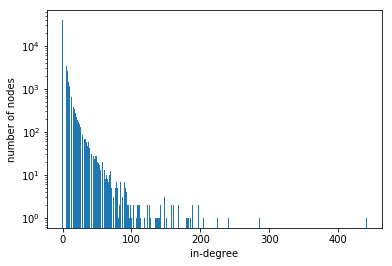

In [46]:
in_degrees = [x[1] for x in graph.in_degree]
degreeCount = collections.Counter(in_degrees)
deg, cnt = zip(*degreeCount.items()) # unroll (degree, count) into different lists for matplotlib

plt.ylabel('number of nodes')
plt.xlabel('in-degree')
plt.bar(deg, cnt, log = True)

**Out-degree (reviews given)**

<BarContainer object of 57 artists>

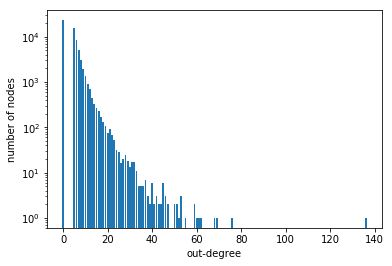

In [39]:
out_degrees = [x[1] for x in graph.out_degree]
degreeCount = collections.Counter(out_degrees)
deg, cnt = zip(*degreeCount.items()) # unroll (degree, count) into different lists for matplotlib

plt.ylabel('number of nodes')
plt.xlabel('out-degree')
plt.bar(deg, cnt, log = True)

## Centrality Measures

## Collaborative Filtering

### Undersampling

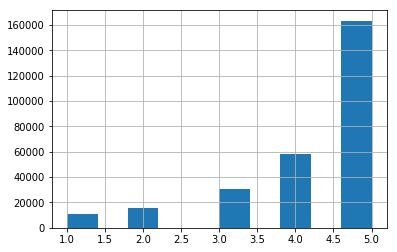

In [22]:
dfull['rating'].hist()

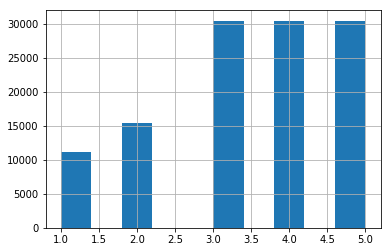

In [23]:
# # Separate majority and minority classes
df_minority = dfull[(dfull.rating!=5) & (dfull.rating!=4)]
df_4 = dfull[dfull.rating==4]
df_5 = dfull[dfull.rating==5]
resampling_count = dfull['rating'].value_counts()[3]
 
# Downsample majority class
df_4_down = resample(df_4, 
                     replace=False,
                     n_samples = resampling_count,
                     random_state=123) # reproducible results

# Downsample majority class
df_5_down = resample(df_5, 
                     replace=False,
                     n_samples = resampling_count,
                     random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_minority, df_4_down, df_5_down])
 
# Display new class counts
df_downsampled['rating'].hist()

### Creating dataset for collaborative filtering

In [24]:
dflearn = df_downsampled
dflearn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117930 entries, 15 to 262698
Data columns (total 3 columns):
productID    117930 non-null object
rating       117930 non-null float64
userID       117930 non-null object
dtypes: float64(1), object(2)
memory usage: 3.6+ MB


In [25]:
# converting strings to categories
series2cat(dflearn, 'productID', 'userID')

# reordering columns for fastai standard format
dflearn = dflearn[['userID', 'productID', 'rating']]
dflearn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117930 entries, 15 to 262698
Data columns (total 3 columns):
userID       117930 non-null category
productID    117930 non-null category
rating       117930 non-null float64
dtypes: category(2), float64(1)
memory usage: 4.8+ MB


In [26]:
# creating collaborative filtering dataset
data = CollabDataBunch.from_df(dflearn, seed=42, valid_pct = 0.2)
data.show_batch()

userID,productID,target
A3M02YQFAJHW07,B001H0F3TK,4.0
A1LMEFZMY0LY7W,B004V96OL0,2.0
A2CQTEDDHLZ3US,B00BXJRKXM,2.0
A1G3UH66R42RY8,B001W97MWC,5.0
A22A19DIHY5L0G,B001HEF6W0,5.0


In [0]:
n_cicles = 5

### EmbeddingDotBias

In [0]:
learn = collab_learner(data, n_factors=50, y_range=(1,5), use_nn = False, callback_fns=ShowGraph)
#learn.loss_func = torch.nn.MSELoss() # changing loss function (default is MSE)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 7.59E-04


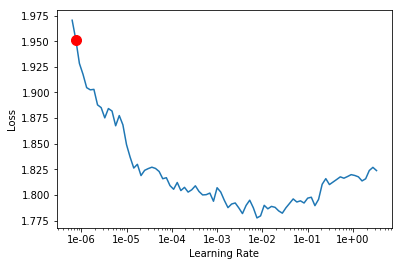

In [29]:
# learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder.plot(suggestion = True) # plot learning rate graph

Training results


epoch,train_loss,valid_loss,time
0,1.782505,1.780767,00:10
1,1.773154,1.777198,00:10
2,1.784532,1.774300,00:10
3,1.808489,1.772889,00:10
4,1.807695,1.772659,00:10


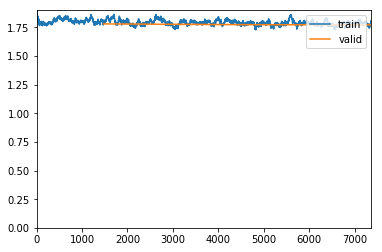

In [30]:
print('Training results')
learn.fit_one_cycle(n_cicles, 1e-4, wd=0.1)

# learn.save('amazon-reviews-dot-1')

In [31]:
learn.predict({
    "userID": 'A1UWP1ZNYQKEA7',
    "productID": 'B00CIZG8GK'
})

(FloatItem 2.997974, tensor(2.9980), tensor(2.9980))

#### Interpretation

https://towardsdatascience.com/collaborative-filtering-with-fastai-3dbdd4ef4f00

In [32]:
g = dflearn.groupby('productID')['rating'].count()
top_ratings = g.sort_values(ascending=False).index.values[:1000]
top_ratings = top_ratings.astype(str)
top_ratings

array(['B005LERHD8', 'B005GYGD7O', 'B000T9VK56', 'B002RADHJC', ..., 'B005LMTW6K', 'B007BZ5CUU', 'B000SMNL2E',
       'B003YJ4RYO'], dtype='<U10')

In [33]:
# get biases for top products
product_bias = learn.bias(top_ratings, is_item=True)

# get mean ratings
mean_ratings = dflearn.groupby('productID')['rating'].mean()
product_ratings = [(b, top_ratings[i], mean_ratings.loc[tb]) for i, (tb, b) in enumerate(zip(top_ratings, product_bias))]

# print product bias information
item0 = lambda o:o[0]
print(sorted(product_ratings, key=item0)[:15])
print(sorted(product_ratings, key=item0, reverse=True)[:15])

# get weights
product_w = learn.weight(top_ratings, is_item=True)

# transform weights to 3 dimensions
product_pca = product_w.pca(3)

# get prinicipal components
fac0,fac1,fac2 = product_pca.t()
product_comp = [(f, i) for f,i in zip(fac0, top_ratings)]

# print fac0 information
print(sorted(product_comp, key=itemgetter(0), reverse=True)[:10])
print(sorted(product_comp, key=itemgetter(0))[:10])

# print fac1 information
product_comp = [(f, i) for f,i in zip(fac1, top_ratings)]
print(sorted(product_comp, key=itemgetter(0), reverse=True)[:10])
print(sorted(product_comp, key=itemgetter(0))[:10])

[(tensor(-0.0298), 'B008KM948O', 2.25), (tensor(-0.0291), 'B00FF394VI', 2.238095238095238), (tensor(-0.0284), 'B00FGPMV74', 2.423076923076923), (tensor(-0.0281), 'B00DNV1IJK', 1.75), (tensor(-0.0278), 'B003QMMSZ4', 2.3823529411764706), (tensor(-0.0251), 'B00FEEA4MG', 2.12), (tensor(-0.0248), 'B000OTRDZ2', 2.55), (tensor(-0.0246), 'B00E8CN6MA', 2.3684210526315788), (tensor(-0.0243), 'B003N9BT7S', 2.6923076923076925), (tensor(-0.0242), 'B000M9JJ7O', 2.638888888888889), (tensor(-0.0241), 'B005D6B5NW', 2.823529411764706), (tensor(-0.0239), 'B00368CL0A', 2.607142857142857), (tensor(-0.0239), 'B0006IT6JC', 2.65625), (tensor(-0.0239), 'B00DM0587K', 2.1176470588235294), (tensor(-0.0230), 'B002K6F79G', 2.706896551724138)]
[(tensor(0.0504), 'B0013KDS96', 4.483870967741935), (tensor(0.0477), 'B008X061B6', 4.173913043478261), (tensor(0.0469), 'B002KMI7OC', 4.041666666666667), (tensor(0.0467), 'B005LERHD8', 3.6054054054054054), (tensor(0.0458), 'B001Q5QLP6', 4.03030303030303), (tensor(0.0452), 'B00

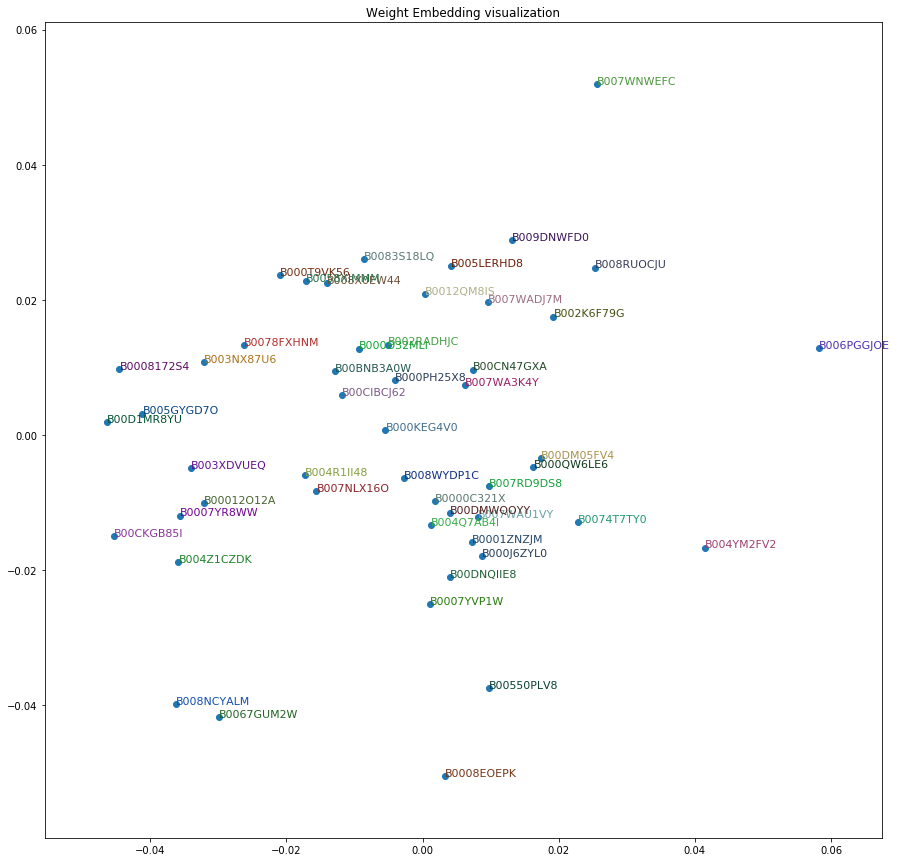

In [34]:
idxs = np.random.choice(len(top_ratings), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_ratings[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.title('Weight Embedding visualization')
plt.show()

### EmeddingNN

In [0]:
learn = collab_learner(data, use_nn=True, emb_szs={'userID': 40, 'productID':40}, layers=[256, 128], y_range=(1, 5))
learn.fit_one_cycle(n_cicles, 1e-3, wd=0.1)

# learn.save('amazon-reviews-nn-1')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
# interp.confusion_matrix()